In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math

In [62]:

device = torch.device("cuda")


class LSTMModel(nn.Module):
    def __init__(self, input_size, forecast_steps):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(128, 64)
        self.tanh = nn.Tanh()
        self.lstm2 = nn.LSTM(64, 64, batch_first=True, num_layers=1)
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(64, forecast_steps)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x = self.tanh(self.dense1(x[:, -1, :]))
        x = x.unsqueeze(1)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = self.output(x.squeeze(1))
        return x

class Conv1DModel(nn.Module):
    def __init__(self, input_size, forecast_steps):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 128, kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(64 *1, 64)
        self.output = nn.Linear(64, forecast_steps)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.tanh(self.conv2(x))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.tanh(self.fc1(x))
        x = self.output(x)
        return x
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=100, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        """
        Checks if training should stop based on validation loss.

        Args:
            val_loss (float): Current validation loss
            model (torch.nn.Module): Current model to be saved if it's the best
        """
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):

        # Save the best model
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [58]:
class DataProcessing(object):
    @staticmethod
    def calculate_macd(log_prices, short_period=12, long_period=26, signal_period=9):
        """Calculate MACD technical indicator"""
        short_ema = log_prices.ewm(span=short_period).mean()
        long_ema = log_prices.ewm(span=long_period).mean()
        macd = short_ema - long_ema
        return macd
    
    @staticmethod
    def calculate_rsi(prices, periods=14):
        """Calculate RSI technical indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def prepare_database(self,ticker, start, end):
        data = yf.download(ticker, start=start, end=end)
        data = pd.DataFrame(data)
        train_dates = pd.to_datetime(data.index)
        data['Date'] = train_dates
        data['Return'] = data['Adj Close'].pct_change()
        data['Price'] = data['Adj Close']
        # Moving averages of log prices
        data['MA5'] = data['Price'].rolling(window=5).mean()
        data['MA20'] = data['Price'].rolling(window=20).mean()
        data['MA50'] = data['Price'].rolling(window=50).mean()
        # Volatility measures (using log returns)
        data['Volatility_5'] = data['Return'].rolling(window=5).std()
        data['Volatility_20'] = data['Return'].rolling(window=20).std()
        # Price momentum indicators
        data['RSI'] = self.calculate_rsi(data['Adj Close'], periods=14)
        data['Momentum'] = (1 + data['Return']).cumprod()
        # Moving average convergence/divergence
        data['MACD'] = self.calculate_macd(data['Return'])
        data.dropna(inplace=True)
        data.reset_index(drop=True, inplace=True)
        data['Response'] = data['Price']
        return data

    @staticmethod
    ## Convert this idea into code
    def Backshift(X,k):
        return np.array(X[:len(X) - k])
    
    @staticmethod
    def stack(X,k):
        return np.array([0] * k + list(X))

    
    def feature_engineering(self, db):
        features =['MA5', 'MA20', 'MA50', 'Volatility_5',
                'Volatility_20', 'RSI', 'Momentum', 'MACD']
        feats = pd.DataFrame(columns=features)
        for feature in features:
            feats[feature] = pd.Series(self.fractional_differenciation(db[feature], 0.5)[0]) 
        feats[features] = StandardScaler().fit_transform(feats[features])

        print(f"These are the features Scaled and transformed /n {feats}")
            
        response, weights = self.fractional_differenciation(db['Response'], 0.5)
        return feats, response
    

    def fractional_differenciation(self, X, d):
        weights = np.zeros(len(X))
        weights[0] = 1
        Array = np.zeros(len(X))
        K = [i for i in range(len(X))]
        for i in range(1,len(X)):
            param = -weights[i-1] * (d - i + 1) / i
            weights[i] = param if abs(param) > 0.01 else 0
        for i in range(len(X)):
            Array += weights[i] * self.stack(self.Backshift(X,i),i)

        filtration = int(d) if d % 1 ==0 else math.ceil(1/(d+0.01))
        return Array[filtration:], weights[:-filtration]
    
    @staticmethod
    def fractional_integration(series, weights):
        array = np.zeros(len(weights))
        for i in range(1, len(weights)):
            numeric = 0
            for j in range(i):
                numeric += weights[i-j] * array[j]
            array[i] = series[i] - numeric

        return array


    def create_sequences(self, db_feat, db_resp, n_steps, forecast_steps):
            X, y = [], []
            for i in range(n_steps, len(db_feat) - forecast_steps + 1):
                X.append(db_feat[i - n_steps:i])
                y.append(db_resp[i:i + forecast_steps])
            X, y = torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(y))
            if len(X.shape) == 3:
                return X,y
            else:
                return X.unsqueeze(-1), y
    
    

In [60]:
class Model_Trainer(object):

    @staticmethod
    def train_model(model, X_train, y_train, epochs=10000, batch_size=32):
        print(f"Training on {device}")

        # Move the model to the primary GPU (cuda:0) first
        model = model.to(device)

        # Wrap the model with DataParallel to use multiple GPUs (cuda:0 and cuda:1)
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs!")
            model = torch.nn.DataParallel(model, device_ids=[0, 1])  # Specify the GPU devices

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # Ensure X_train and y_train are the correct shapes
        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)

        # Move the data to the selected device (primary GPU)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        for epoch in range(epochs):
            model.train()
            # Create DataLoader to handle batching
            dataset = TensorDataset(X_train, y_train)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            for batch_X, batch_y in dataloader:
                # Move batch data to the same device as the model
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

            # Print loss every 1000th epoch
            if epoch % 10 == 0:  # Print every 1000th epoch
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

        return model


class StockPredictor():
    @staticmethod
    def general_prediction(X, y, n_steps, forecast_days):
        Processor = DataProcessing()
        X_train, y_train, y_test = X[:-252], y[:-252], y[-252:]
        X_train_seq, y_train_seq = Processor.create_sequences(X_train, y_train, n_steps, forecast_days)

        # Initialize models
        print(X_train_seq.shape)
        print(y_train_seq.shape)
        model1 = LSTMModel(X_train_seq.shape[2], forecast_days).to(device)
        model2 = Conv1DModel(X_train_seq.shape[2], forecast_days).to(device)

        # Train models
        Trainer = Model_Trainer()
        model1 = Trainer.train_model(model1, X_train_seq, y_train_seq, epochs=5)
        model2 = Trainer.train_model(model2, X_train_seq, y_train_seq, epochs=300)

        # Predict
        model1.eval()
        model2.eval()
        with torch.no_grad():
            predicted_response_1 = model1(X_train_seq[-1:].to(device)).cpu().numpy()
            predicted_response_2 = model2(X_train_seq[-1:].to(device)).cpu().numpy()
        return predicted_response_1, predicted_response_2, y_test[:forecast_days], np.array(y_train[-forecast_days:])



    @staticmethod
    def run_prediction(ticker, start, end, n_steps, forecast_days):
        # Prepare data
        Processor = DataProcessing()
        dataset = Processor.prepare_database(ticker, start, end)
        X,y = Processor.feature_engineering(dataset)

        X_train, y_train, y_test = X[:-252], y[:-252], y[-252:]
        X_train_seq, y_train_seq = Processor.create_sequences(X_train, y_train, n_steps, forecast_days)

        # Initialize models
        
        model1 = LSTMModel(X_train_seq.shape[2], forecast_days).to(device)
        model2 = Conv1DModel(X_train_seq.shape[2], forecast_days).to(device)

        # Train models
        Trainer = Model_Trainer()
        model1 = Trainer.train_model(model1, X_train_seq, y_train_seq, epochs=5)
        model2 = Trainer.train_model(model2, X_train_seq, y_train_seq, epochs=300)

        # Predict
        model1.eval()
        model2.eval()
        with torch.no_grad():
            predicted_response_1 = model1(X_train_seq[-1:].to(device)).cpu().numpy()
            predicted_response_2 = model2(X_train_seq[-1:].to(device)).cpu().numpy()

        return predicted_response_1, predicted_response_2, y_test[:forecast_days], np.array(y_train[-forecast_days:])

    @staticmethod
    def plot_and_visualize_model(historical_data, p1, p2, y_seq, forecast_days):
        # Ensure historical_data is a DataFrame
        historical_data = pd.DataFrame(historical_data)

        # Calculate R² scores
        mod1_r2 = r2_score(y_seq, p1[0])
        mod2_r2 = r2_score(y_seq, p2[0])

        # Prepare x-axis values
        historical_x = list(range(len(historical_data)))
        prediction_x = list(range(len(historical_data), len(historical_data) + int(forecast_days)))

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(historical_x, historical_data.values, color='black', label="Historical Responses")
        # ax.plot(prediction_x, p1[0], color='blue', label="LSTM Predicted Response")
        ax.plot(prediction_x, p2[0], color='red', label="Conv1D Predicted Response")
        ax.plot(prediction_x, y_seq, color='green', label="Actual Response")

        # Add a text box with improved readability
        metrics_text = f"Metrics:\nModel 1 R² Score = {mod1_r2:.4f}\nModel 2 R² Score = {mod2_r2:.4f}"
        ax.text(
            0.02, 0.98, metrics_text, transform=ax.transAxes,
            fontsize=10, color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"),
            verticalalignment='top', horizontalalignment='left'
        )

        # Add labels and legend
        ax.set_title("Models Prediction Comparison Graphs")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Response")
        ax.legend()

        # Display the plot
        plt.show()

        return plt.gcf()
    
    def general_visualization(self, X, y,  timestep, steps):
        p1, p2, y_seq, historical = self.general_prediction(X,y,timestep, steps)
        fig = self.plot_and_visualize_model(historical, p1, p2, y_seq, steps)
        return fig


    def visualize_plot(self,ticker, start, end, timestep, steps):
        p1, p2, y_seq, historical_data = self.run_prediction(ticker, start, end, timestep, steps)
        print(len(historical_data))
        fig = self.plot_and_visualize_model(historical_data, p1, p2, y_seq, steps)
        return fig


In [ ]:
# StockPredictor().visualize_plot("AMZN", "2012-01-01", "2025-02-01", 30,50)

In [ ]:
X_space = np.linspace(0, 60, 1000)
Y= []
for X in X_space:
    Y.append(math.sin(X))

torch.Size([9741, 3, 1])
torch.Size([9741, 5])
Training on cuda
X_train shape: torch.Size([9741, 3, 1])
y_train shape: torch.Size([9741, 5])
Epoch 1/5, Loss: 0.6496792435646057
Training on cuda
X_train shape: torch.Size([9741, 3, 1])
y_train shape: torch.Size([9741, 5])
Epoch 1/300, Loss: 0.4924650490283966
Epoch 11/300, Loss: 0.36085036396980286
Epoch 21/300, Loss: 0.6375773549079895
Epoch 31/300, Loss: 0.3336971700191498
Epoch 41/300, Loss: 0.3561822772026062
Epoch 51/300, Loss: 0.47090891003608704
Epoch 61/300, Loss: 0.4667022228240967
Epoch 71/300, Loss: 0.24791735410690308
Epoch 81/300, Loss: 0.4292604923248291
Epoch 91/300, Loss: 0.4629921317100525
Epoch 101/300, Loss: 0.4380694329738617
Epoch 111/300, Loss: 0.557011067867279
Epoch 121/300, Loss: 0.4704982042312622
Epoch 131/300, Loss: 0.40648362040519714
Epoch 141/300, Loss: 0.4767478406429291
Epoch 151/300, Loss: 0.25771793723106384
Epoch 161/300, Loss: 0.3365436792373657
Epoch 171/300, Loss: 0.3709990382194519
Epoch 181/300, L

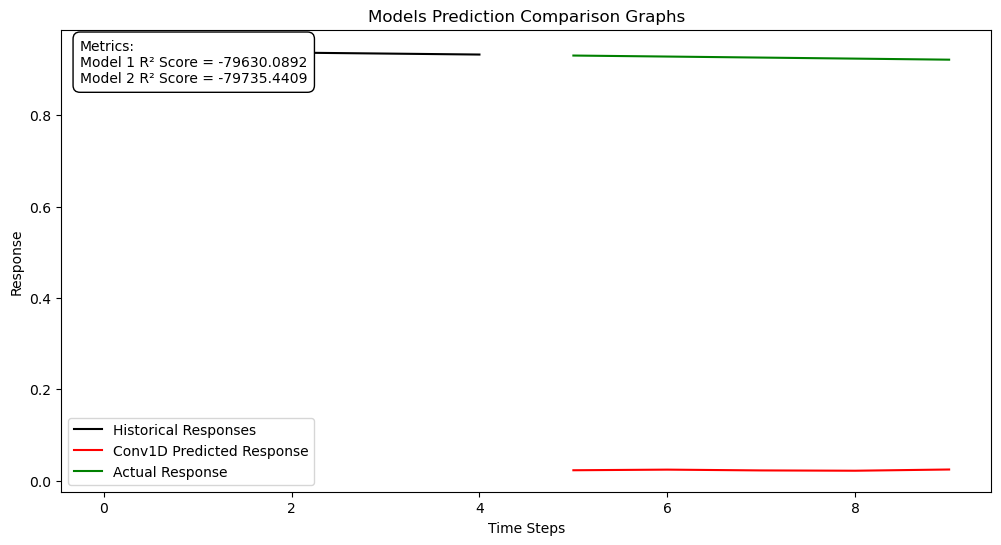

TypeError: cannot unpack non-iterable Figure object

<Figure size 640x480 with 0 Axes>

In [64]:
X_seq, Y_Seq = StockPredictor().general_visualization(X_space,Y,3,5)
